In [410]:
'''analyse du prix moyens de vente de l'immobilier résidentiel londonien.
Prix moyen en livres sterlings. Données mensuelles de janvier 2016 à juillet 2017.

Mesure mensuelle 01/01/1969 à 01/01/2016
Données reservées : 01/02/2016 à 01/07/2017

approche Box/Jenkins
->identification du modèle : tendances, saisonnalité, autorégression
->estimation des paramètre
->vérification sur données/ex post et mesure du résidu non prévu'''

import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from scipy import stats
from pmdarima import auto_arima

In [411]:
def dickeyFuller(timeseries):
    '''test de Dicker-Fuller - série stationnaire ?
    p<= 0.05 = rejet hypothèse nulle (donc stationnaire)
    Test statistic : au plus négatif, au moins probable que non stationnaire
    et comparer test avec les critical values pour probabilité'''
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries) #, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [412]:
def difference(dataset, interval=1):
    '''retourne la différence (ordinaire par défaut) d'une série'''
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [452]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [413]:
df = pd.read_csv("Average-prices-2017-07.csv", parse_dates=['Date'])
df.tail(10)

,Date,Region_Name,Area_Code,Average_Price,Monthly_Change,Annual_Change,Average_Price_SA
117926,2017-07-01,Slough,E06000039,303181.1659,0.395836,2.649061,NaN
117927,2017-07-01,Windsor and Maidenhead,E06000040,479214.3857,-0.540947,-1.198457,NaN
117928,2017-07-01,Wokingham,E06000041,411963.6771,-0.460969,0.021207,NaN
117929,2017-07-01,Milton Keynes,E06000042,262570.1828,0.725188,3.781561,NaN
117930,2017-07-01,Newport,W06000022,159210.1160,0.257474,5.071956,NaN
117931,2017-07-01,Hartlepool,E06000001,106974.4414,0.648137,-0.205251,NaN
117932,2017-07-01,Middlesbrough,E06000002,114874.1618,5.590396,0.411657,NaN
117933,2017-07-01,England and Wales,K04000001,237720.8481,0.906923,5.235017,233305.4486
117934,2017-07-01,Great Britain,K03000001,229247.8352,1.091217,5.267496,224618.9236
117935,2017-07-01,United Kingdom,K02000001,226184.5575,1.065672,5.140036,221703.8031


In [414]:
df = df.set_index('Date')

In [415]:
df = df.loc[df['Region_Name'] == 'London', ['Average_Price']]

In [416]:
df.tail()

,Average_Price
Date,
2017-03-01,475400.1275
2017-04-01,477734.4729
2017-05-01,480431.5968
2017-06-01,487321.5440
2017-07-01,488729.2292


In [417]:
#séparer données à analyser et données pour prévisions ex post.

start_date = dt.datetime(1995, 1, 1)
end_date = dt.datetime(2016,1,1)
analyse_df = df[start_date:end_date]
reserve_df = df[end_date:]
reserve_df = reserve_df.drop([end_date]) #dropper première valeur, sinon doublons une période

In [418]:
#analyse_df.to_csv("housingFiltered.csv")
#reserve_df.to_csv("donneesReservees.csv")
analyse_df.shape

(253, 1)

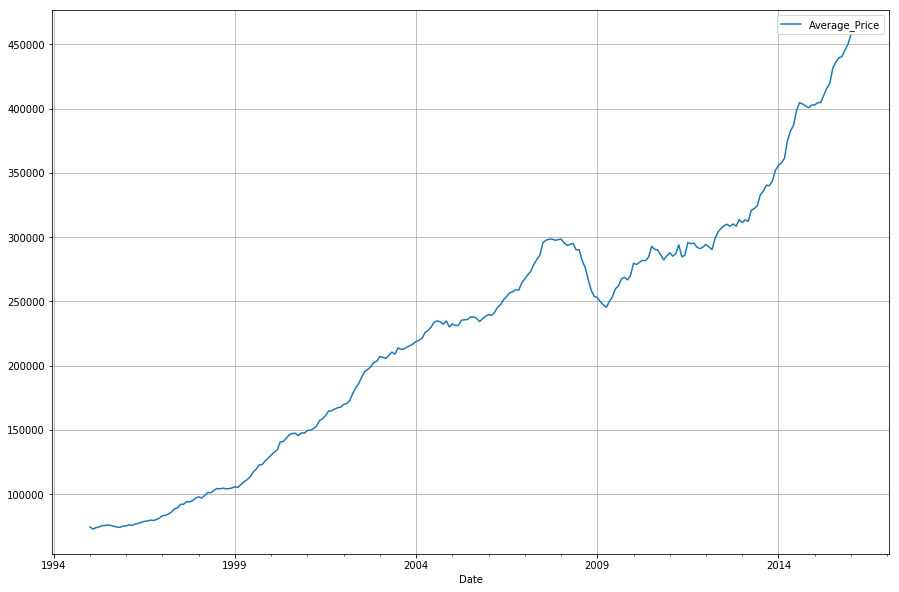

In [419]:
#A quoi ressemble notre série ?

rcParams['figure.figsize'] = [15.0, 10.0]
analyse_df.plot(grid=True)

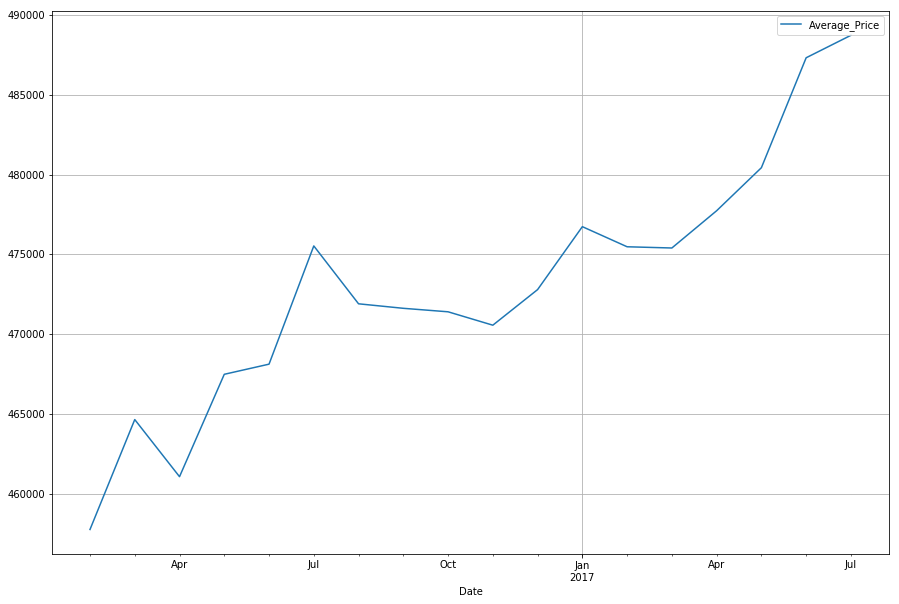

In [420]:
rcParams['figure.figsize'] = [15.0, 10.0] 
reserve_df.plot(grid=True)

In [421]:
#et statistiquement ?

print("std dev : {} \n min : {} \n max : {} \n medianne : {} \n moyenne : {}".format(analyse_df['Average_Price'].std(),
                                                                                     analyse_df['Average_Price'].min(), 
                                                                                     analyse_df['Average_Price'].max(), 
                                                                                     analyse_df['Average_Price'].median(),
                                                                                     analyse_df['Average_Price'].mean()))

std dev : 99647.80649005574 
 min : 72777.93708999999 
 max : 457465.5885 
 medianne : 235898.8337 
 moyenne : 225821.92033533598


In [422]:
#Avons nous des outliers (diff de plus de 3dev std) ?

outlierPositif = analyse_df['Average_Price'] > analyse_df['Average_Price'].mean() + analyse_df['Average_Price'].std()*3
outlierNegatif = analyse_df['Average_Price'] < analyse_df['Average_Price'].mean() - analyse_df['Average_Price'].std()*3

print("outliers positifs : {}".format(analyse_df[outlierPositif]))
print("outliers négatifs : {}".format(analyse_df[outlierNegatif]))



outliers positifs : Empty DataFrame
Columns: [Average_Price]
Index: []
outliers négatifs : Empty DataFrame
Columns: [Average_Price]
Index: []


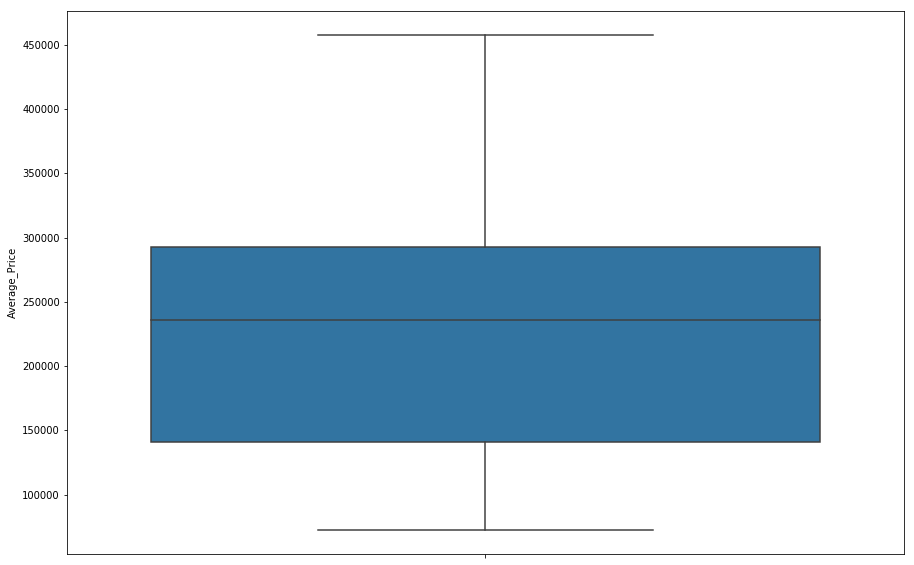

In [423]:
#idem graphiquement, a-t-on des outliers ?

sns.boxplot(analyse_df['Average_Price'], orient='v')

In [424]:
#ajout d'une colonne index pour pouvoir tracer regplot avec Seaborn (supporte pas datetime):
analyse_df.insert(analyse_df.shape[1],'date2', analyse_df.index.value_counts().sort_index().cumsum())

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


[]

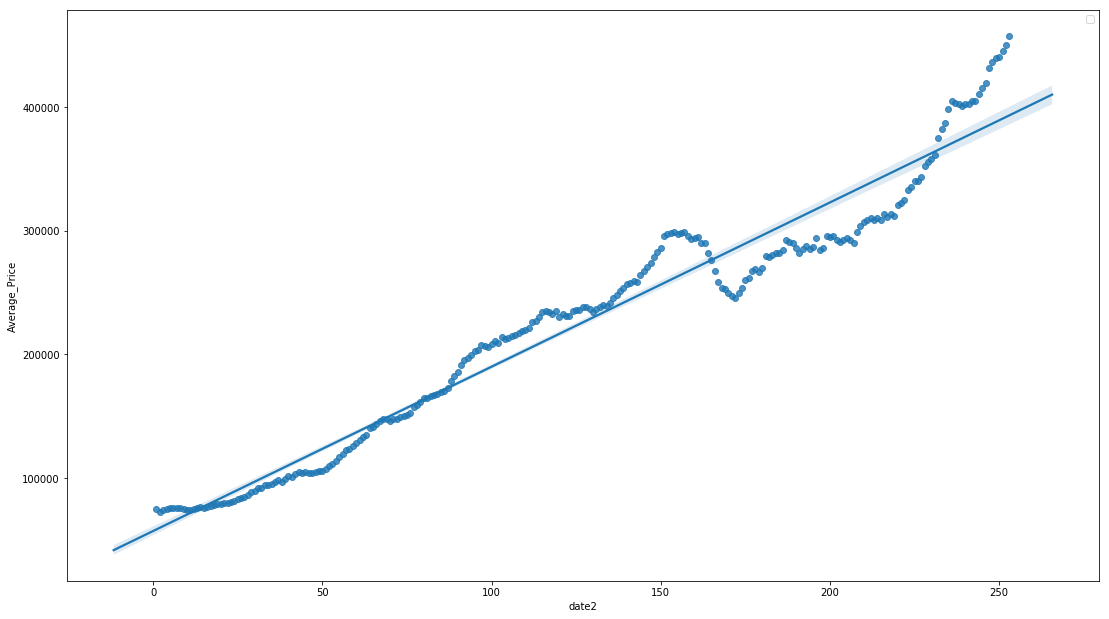

In [425]:
#regression lineaire simple - cf fichier Excel

fig = sns.regplot(x='date2', y='Average_Price', data=analyse_df)
fig.figure.set_size_inches(18.5, 10.5)
fig.legend()
fig.plot()


count      241.000000
mean      -145.466046
std       2570.839986
min     -10020.070919
25%      -1592.998355
50%       -177.547303
75%       1115.212043
max       9707.068886
Name: Average_Price, dtype: float64


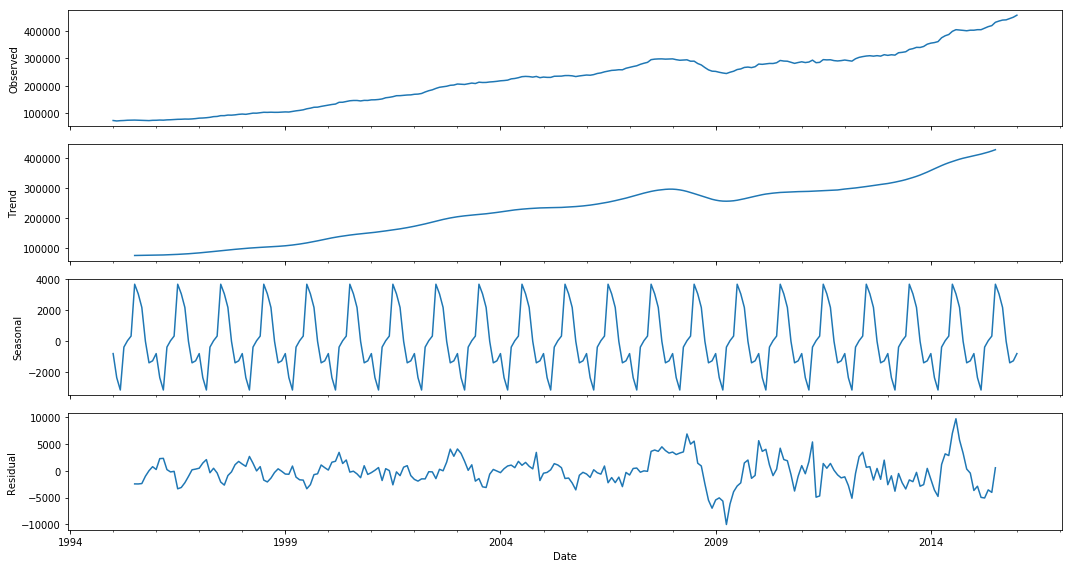

In [426]:
#décomposition - modèle additif
import statsmodels.api as sm
decompo = sm.tsa.seasonal_decompose(analyse_df['Average_Price'], model = 'additive')
rcParams['figure.figsize'] = [15.0, 8.0] 
decompo.plot()
#decompo.resid.plot(kind='kde')
print(decompo.resid.describe())

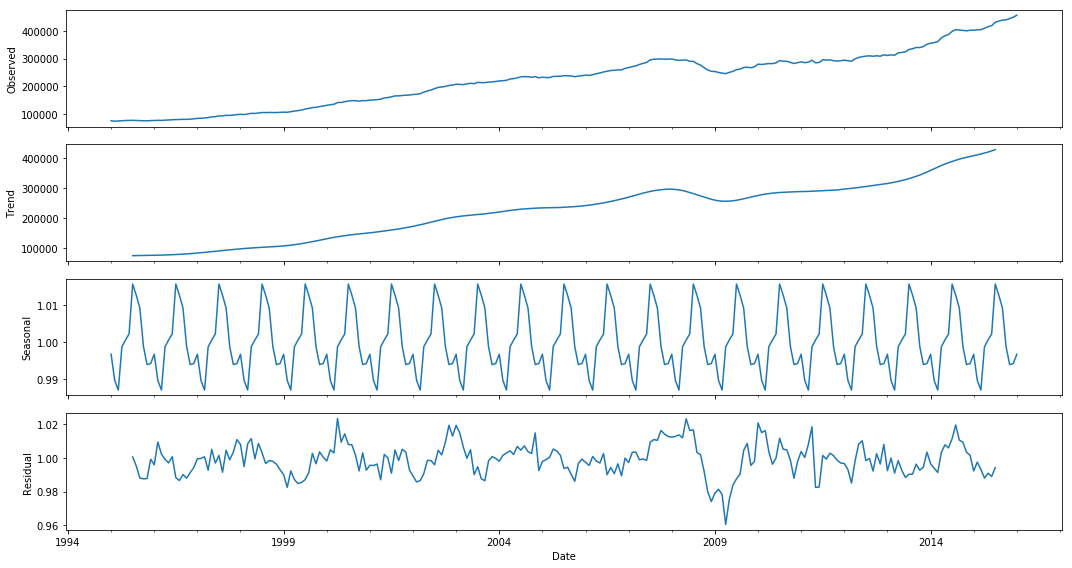

Date
1995-01-01         NaN
1995-02-01         NaN
1995-03-01         NaN
1995-04-01         NaN
1995-05-01         NaN
1995-06-01         NaN
1995-07-01    1.000611
1995-08-01    0.995263
1995-09-01    0.988108
1995-10-01    0.987629
1995-11-01    0.987789
1995-12-01    0.999267
1996-01-01    0.995981
1996-02-01    1.009502
1996-03-01    1.002345
1996-04-01    0.999209
1996-05-01    0.997100
1996-06-01    1.000730
1996-07-01    0.988377
1996-08-01    0.986632
1996-09-01    0.990180
1996-10-01    0.987982
1996-11-01    0.991243
1996-12-01    0.994307
1997-01-01    0.999524
1997-02-01    0.999711
1997-03-01    1.000749
1997-04-01    0.992736
1997-05-01    1.005107
1997-06-01    0.996978
                ...   
2013-08-01    0.990443
2013-09-01    0.996333
2013-10-01    0.992723
2013-11-01    0.994603
2013-12-01    1.003491
2014-01-01    0.996644
2014-02-01    0.993961
2014-03-01    0.991408
2014-04-01    1.003345
2014-05-01    1.007804
2014-06-01    1.006007
2014-07-01    1.011504
2014-0

In [427]:
#decomposition - modele multiplicatif
decompo = sm.tsa.seasonal_decompose(analyse_df['Average_Price'], model = 'multiplicative')
rcParams['figure.figsize'] = [15.0, 8.0] 
decompo.plot()

#decompo.resid.plot(kind='kde')
#decompo.resid.describe()

#decompo.seasonal.plot()
#plt.ylabel("facteur")
plt.show()
analyse_df.insert(analyse_df.shape[1],'desaison', decompo.resid.dropna())
print(analyse_df['desaison'])

In [428]:
#saisonnalité : CMA12 ; fact saisonnal = y/CMA12 ; déterminer moyenne (ou med ou moy élaguée si outliers) mensuelle ;
#somme des moyennes -> 12? Si pas, corriger ; 
print(analyse_df["desaison"].dropna())

Date
1995-07-01    1.000611
1995-08-01    0.995263
1995-09-01    0.988108
1995-10-01    0.987629
1995-11-01    0.987789
1995-12-01    0.999267
1996-01-01    0.995981
1996-02-01    1.009502
1996-03-01    1.002345
1996-04-01    0.999209
1996-05-01    0.997100
1996-06-01    1.000730
1996-07-01    0.988377
1996-08-01    0.986632
1996-09-01    0.990180
1996-10-01    0.987982
1996-11-01    0.991243
1996-12-01    0.994307
1997-01-01    0.999524
1997-02-01    0.999711
1997-03-01    1.000749
1997-04-01    0.992736
1997-05-01    1.005107
1997-06-01    0.996978
1997-07-01    1.001501
1997-08-01    0.991539
1997-09-01    1.004560
1997-10-01    0.998936
1997-11-01    1.003461
1997-12-01    1.010923
                ...   
2013-02-01    0.999982
2013-03-01    0.991086
2013-04-01    0.998462
2013-05-01    0.992653
2013-06-01    0.988448
2013-07-01    0.990329
2013-08-01    0.990443
2013-09-01    0.996333
2013-10-01    0.992723
2013-11-01    0.994603
2013-12-01    1.003491
2014-01-01    0.996644
2014-0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


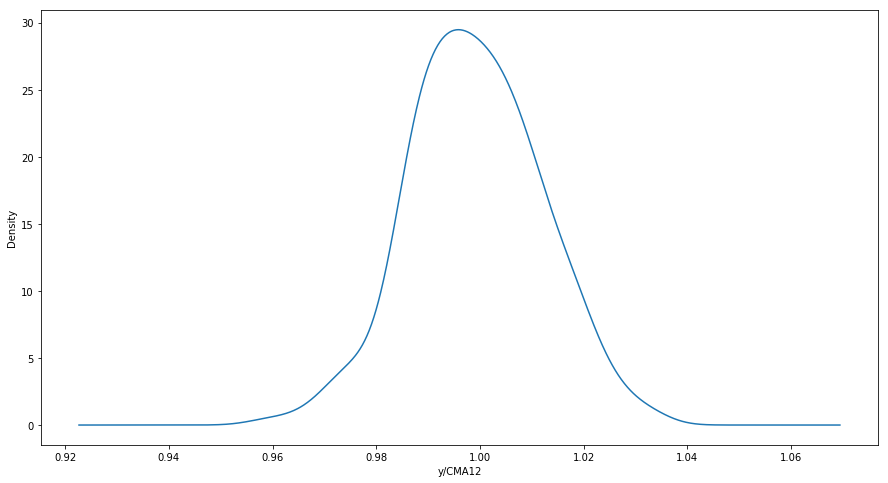

Std dev : 0.0126859507950705 ; min : 0.9593606040451141 ; max : 1.0327258164532036 ; mean : 0.9991368871619001


In [429]:
analyse_df['CMA12'] = analyse_df['Average_Price'].rolling(window=12, center=True).mean().rolling(window=2).mean().shift(-1)
#période MM pair -> MM2 de MM12 pour centrer

analyse_df['seasonal_factor'] = analyse_df['Average_Price'] / analyse_df['CMA12']
analyse_df['seasonal_factor'].plot(kind='kde') #outliers ?
plt.xlabel("y/CMA12")
plt.show()
print("Std dev : {} ; min : {} ; max : {} ; mean : {}".format(analyse_df['seasonal_factor'].std(),
                                                  analyse_df['seasonal_factor'].min(),
                                                  analyse_df['seasonal_factor'].max(),
                                                  analyse_df['seasonal_factor'].mean()))


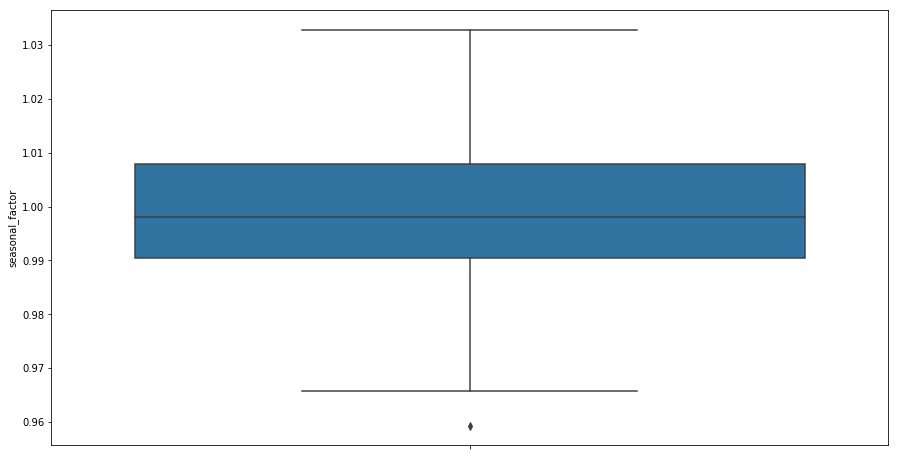

In [430]:
sns.boxplot(analyse_df['seasonal_factor'], orient='v')

In [431]:
moy_fact_sais = []
#moyenne mensuelle, pour toutes les années:
for months in range(1,13):
    moy_fact_sais.append(analyse_df[analyse_df.index.month == months].seasonal_factor.mean())
#normalisation à moyenne de 1 :
for i, val in enumerate(moy_fact_sais):
    moy_fact_sais[i] = float(val * 12.00 / sum(moy_fact_sais))
print("moyennes saisonnieres, en base 12 : {} -- somme totale (=12?) : {}".format(moy_fact_sais, sum(moy_fact_sais)))



moyennes saisonnieres, en base 12 : [0.9967624810337895, 0.9896092374806283, 0.9869155657248074, 0.9985839276528178, 1.0003429332050457, 1.0019266823045074, 1.0153850430202793, 1.0123037284048613, 1.0087841680829728, 0.9983596009783015, 0.9934361369005916, 0.9936672699035892] -- somme totale (=12?) : 11.996076774692192


In [432]:
'''idem que TSE : 
 Computing seasonal coefficients.
 Seasonal coefficients :
  S( 7) =         1.015
  S( 8) =         1.012
  S( 9) =         1.010
  S(10) =         0.999
  S(11) =         0.994
  S(12) =         0.994
  S( 1) =         0.997
  S( 2) =         0.989
  S( 3) =         0.987
  S( 4) =         1.000
  S( 5) =         1.001
  S( 6) =         1.002'''

'idem que TSE : \n Computing seasonal coefficients.\n Seasonal coefficients :\n  S( 7) =         1.015\n  S( 8) =         1.012\n  S( 9) =         1.010\n  S(10) =         0.999\n  S(11) =         0.994\n  S(12) =         0.994\n  S( 1) =         0.997\n  S( 2) =         0.989\n  S( 3) =         0.987\n  S( 4) =         1.000\n  S( 5) =         1.001\n  S( 6) =         1.002'

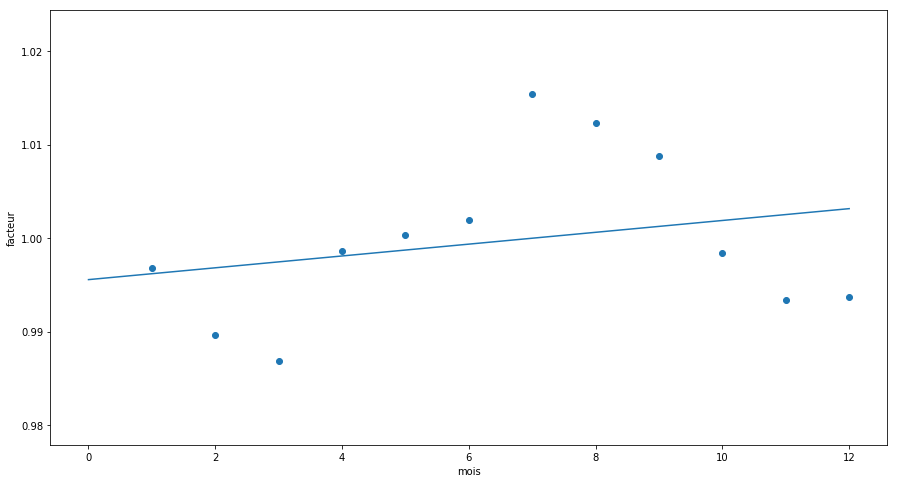

coefficient de X : [0.00063233] 
 terme indépendante : 0.9955629516579573


In [433]:
#régression linéaire (ordinary least square) :
x = pd.DataFrame({"x" : range(1,13)})
model = LinearRegression(fit_intercept = True)
model.fit(x, moy_fact_sais)

xfit = np.linspace(0, 12, 5)
yfit = model.predict(xfit[:, np.newaxis])

# plot
plt.scatter(x, moy_fact_sais)
plt.plot(xfit, yfit);
plt.xlabel("mois")
plt.ylabel("facteur")
plt.show()

#coef et constante ?
print("coefficient de X : {} \n terme indépendante : {}".format(model.coef_, model.intercept_))


In [434]:
#stationnaire ? (cf supra) -> p = 0.99 / non stationnaire
dickeyFuller(analyse_df['Average_Price'])

Results of Dickey-Fuller Test:
Test Statistic                   1.487713
p-value                          0.997478
#Lags Used                      16.000000
Number of Observations Used    236.000000
Critical Value (1%)             -3.458366
Critical Value (5%)             -2.873866
Critical Value (10%)            -2.573339
dtype: float64


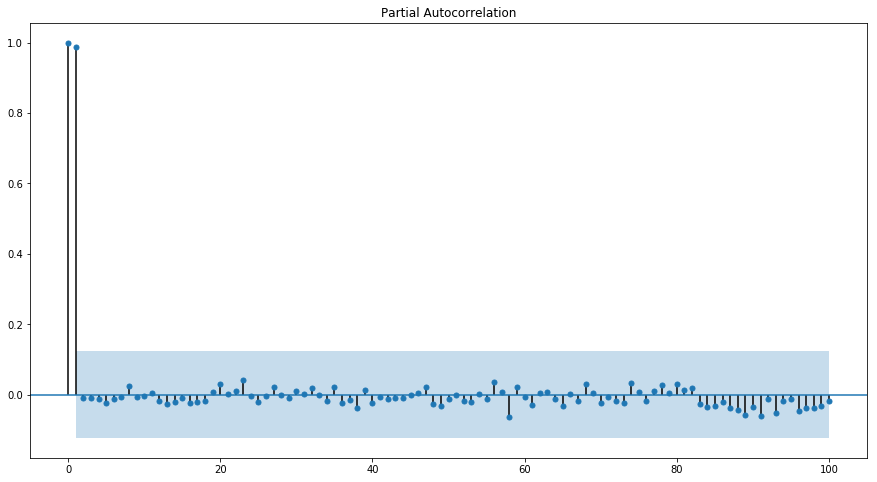

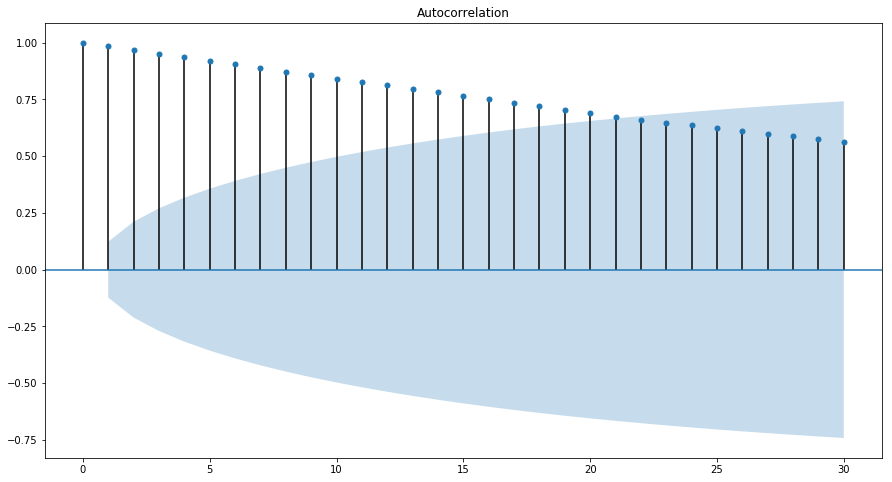

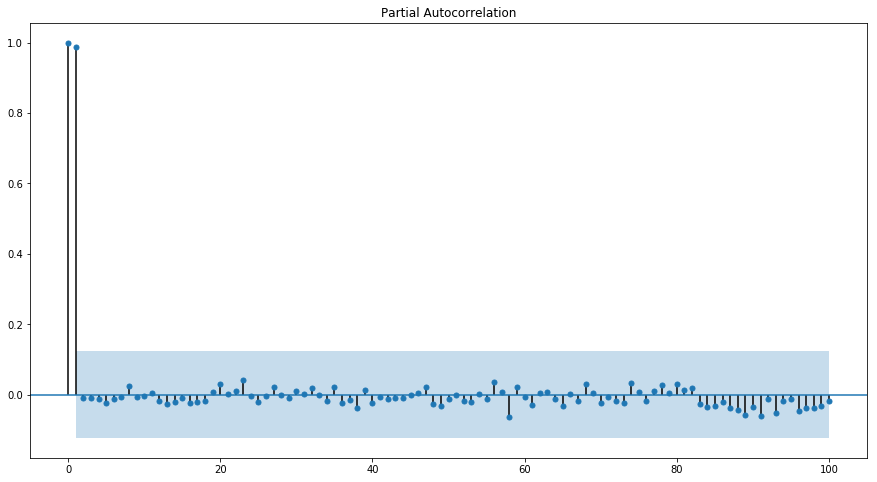

In [435]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(analyse_df['Average_Price'], lags= 30)
plot_pacf(analyse_df['Average_Price'], lags=100)

#analyse : autocorrélé pour les 21 premières (IC99%).

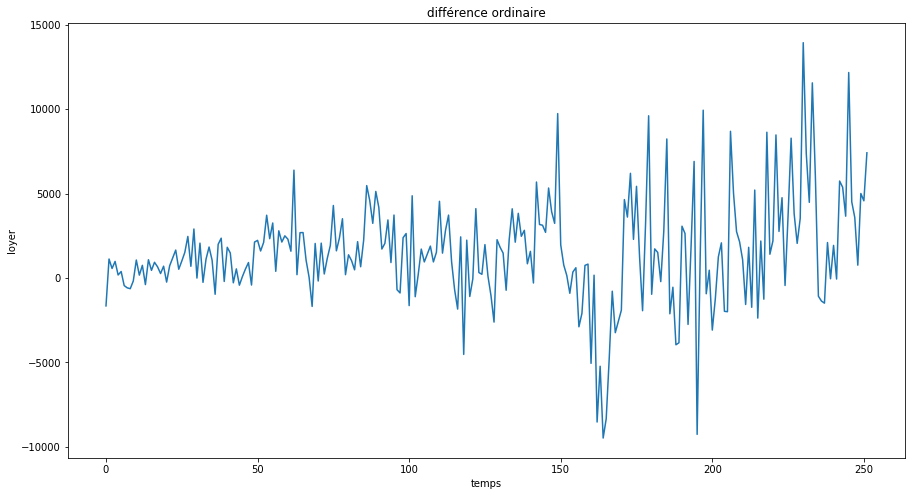

Results of Dickey-Fuller Test:
Test Statistic                  -4.103193
p-value                          0.000957
#Lags Used                      15.000000
Number of Observations Used    236.000000
Critical Value (1%)             -3.458366
Critical Value (5%)             -2.873866
Critical Value (10%)            -2.573339
dtype: float64


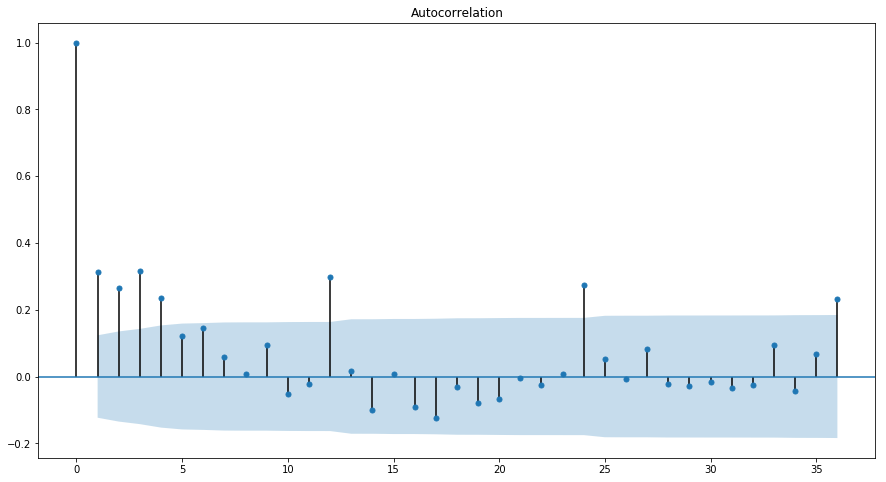

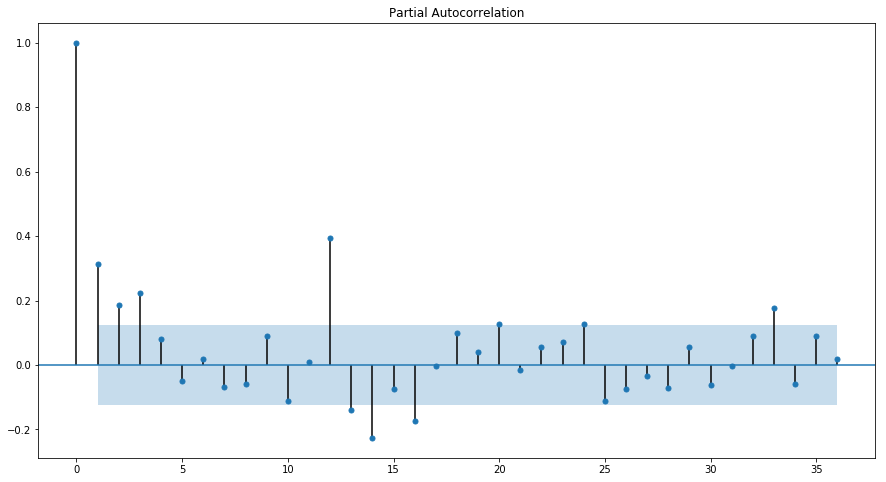

In [436]:
#stationnariser la série :
#
#différence ordinaire (x(t) = x(t) - x(t-1) et/ou saisonnière x(t) = x(t) - x(t-12),
#ensuite refaire autocorrél/Dickey-Fuller -> si ok, plus d’autocorrél)

difference_ordinaire = difference(analyse_df['Average_Price'])
plt.plot(difference_ordinaire)
plt.title("différence ordinaire")
plt.xlabel("temps")
plt.ylabel("loyer")
plt.show()
plot_acf(difference_ordinaire, lags=36)
plot_pacf(difference_ordinaire, lags=36)
dickeyFuller(difference_ordinaire)

#ou prendre résidu de la décompo ?? -> Visiblement, non...
#plot_acf(analyse_df['desaison'].dropna())
#plot_pacf(analyse_df['desaison'].dropna())
#dickeyFuller(analyse_df['desaison'].dropna())

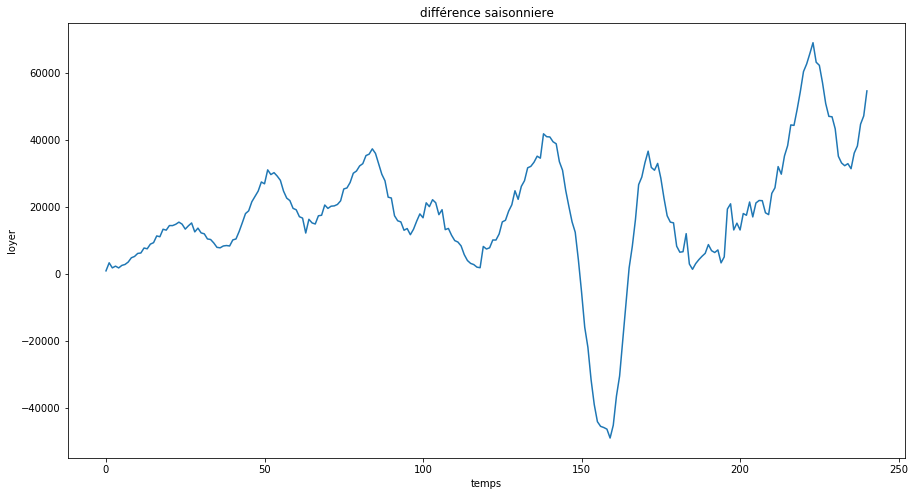

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


Results of Dickey-Fuller Test:
Test Statistic                  -1.611244
p-value                          0.477323
#Lags Used                      15.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


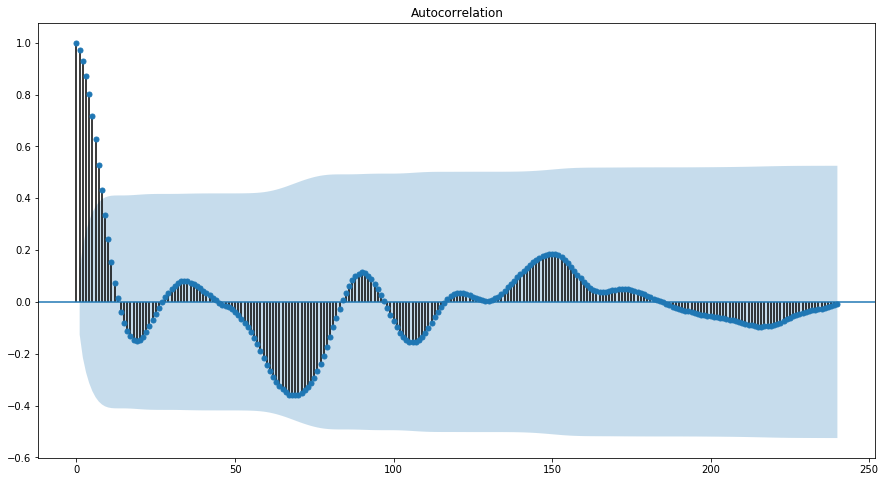

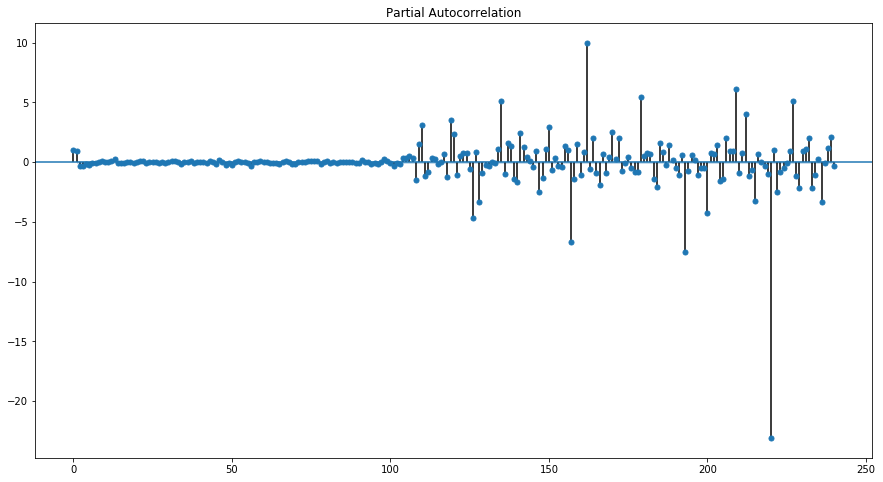

In [437]:
#Toujours autocorrélation lags=5... Essais avec différence saisonnière uniquement ?
difference_saiso = difference(analyse_df['Average_Price'], 12)
plt.plot(difference_saiso)
plt.title("différence saisonniere")
plt.xlabel("temps")
plt.ylabel("loyer")
plt.show()
plot_acf(difference_saiso)
plot_pacf(difference_saiso)
dickeyFuller(difference_saiso)

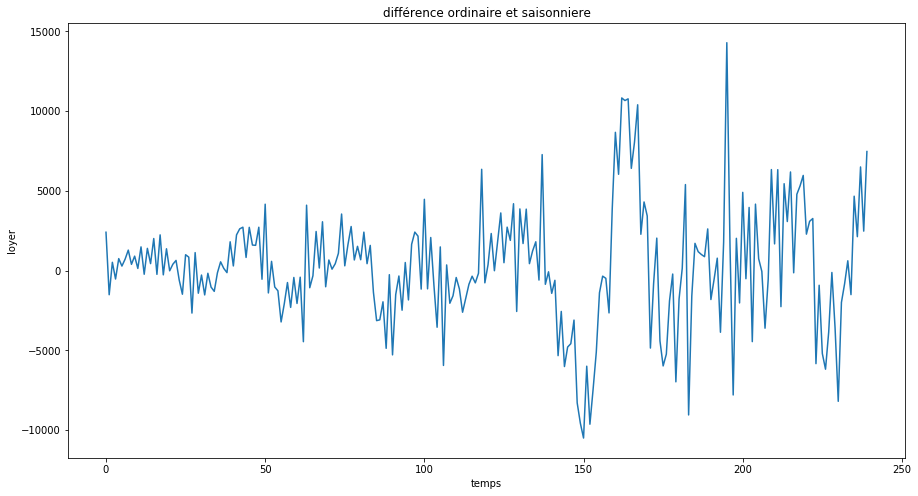

Results of Dickey-Fuller Test:
Test Statistic                  -4.957178
p-value                          0.000027
#Lags Used                      13.000000
Number of Observations Used    226.000000
Critical Value (1%)             -3.459620
Critical Value (5%)             -2.874415
Critical Value (10%)            -2.573632
dtype: float64


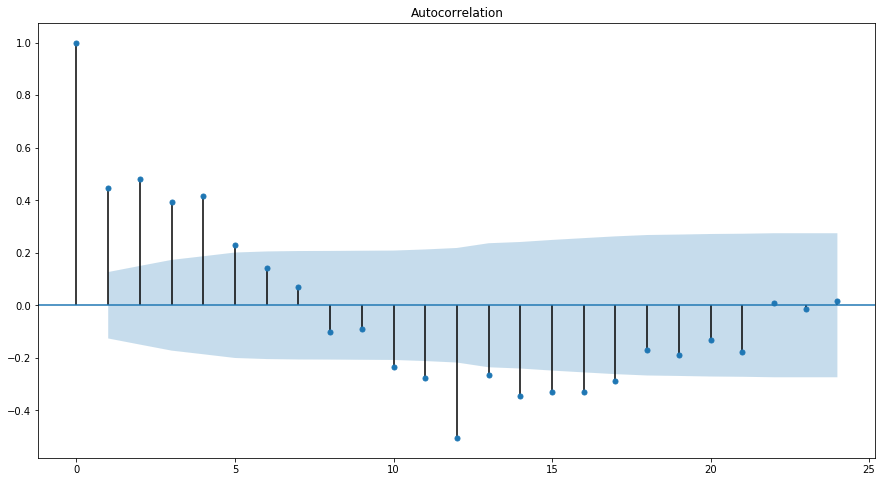

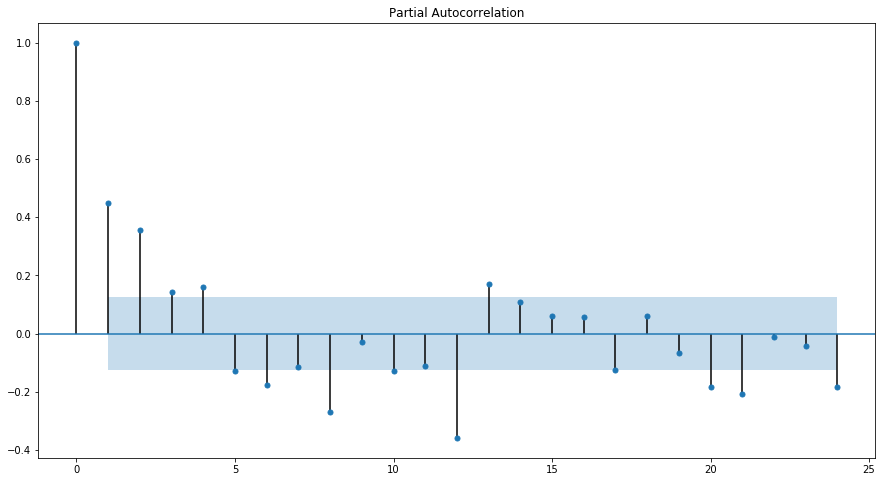

In [438]:
#Essais avec difference ordinaire ET saisonnière (t=12)

difference_ord_sais = difference(difference_ordinaire, 12)
plt.plot(difference_ord_sais)
plt.title("différence ordinaire et saisonniere")
plt.xlabel("temps")
plt.ylabel("loyer")
plt.show()
plot_acf(difference_ord_sais, lags=24)
plot_pacf(difference_ord_sais, lags=24)
dickeyFuller(difference_ord_sais)

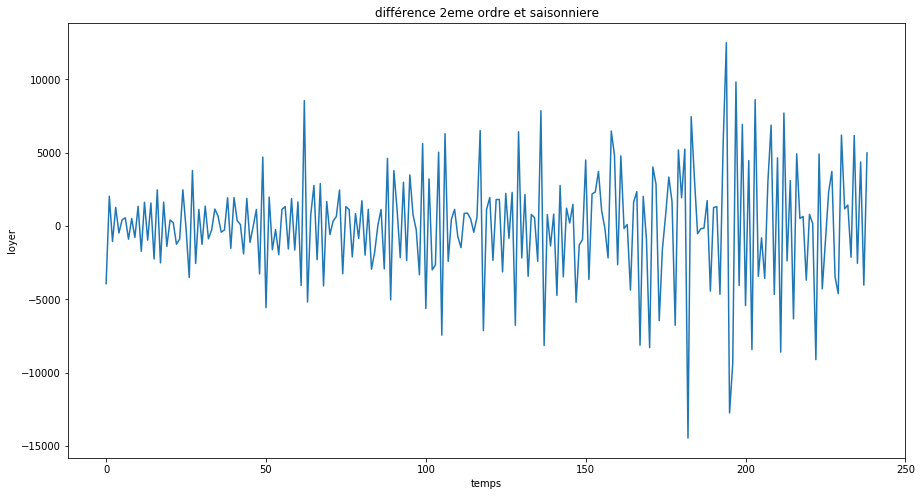

Results of Dickey-Fuller Test:
Test Statistic                -7.421699e+00
p-value                        6.710004e-11
#Lags Used                     1.400000e+01
Number of Observations Used    2.240000e+02
Critical Value (1%)           -3.459885e+00
Critical Value (5%)           -2.874531e+00
Critical Value (10%)          -2.573694e+00
dtype: float64


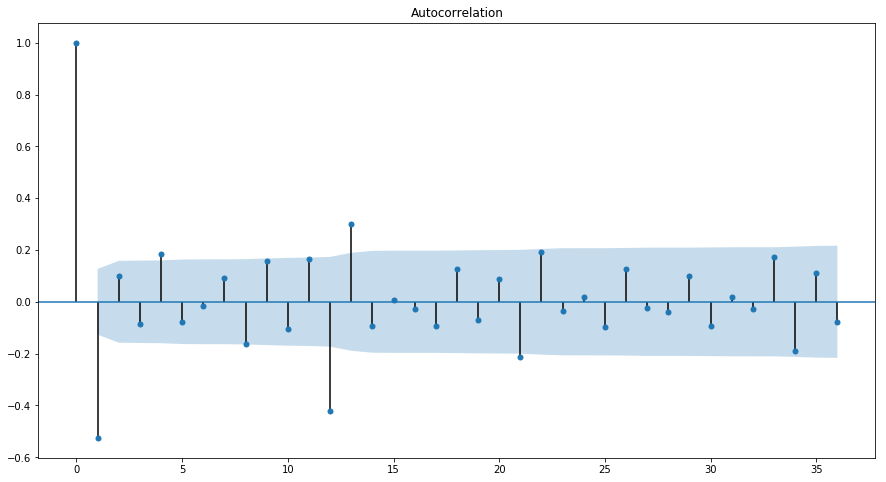

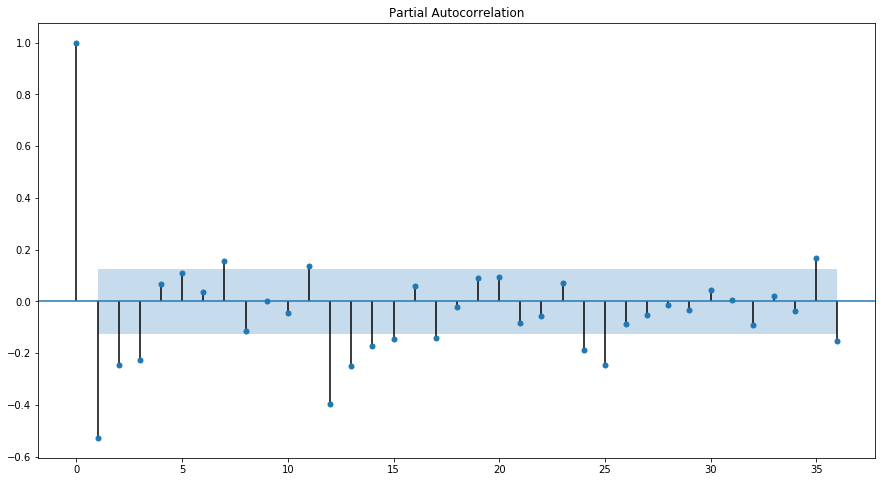

In [439]:
#Essais avec difference ordre 2 + saisonnière (t=12)

difference_ord2_sais = difference(difference_ordinaire, 12)
difference_ord2_sais = difference(difference_ord2_sais)
plt.plot(difference_ord2_sais)
plt.title("différence 2eme ordre et saisonniere")
plt.xlabel("temps")
plt.ylabel("loyer")
plt.show()
plot_acf(difference_ord2_sais, lags=36)
plot_pacf(difference_ord2_sais, lags=36)
dickeyFuller(difference_ord2_sais)

In [440]:
#AUTOARIMA de manière itérative sur le résultat de la transfo ordre2+saison.
arima_diff_model = auto_arima(difference_ord2_sais, start_p=1, start_q=1,max_p=5, max_q=3,
                            seasonal=False,d=1, trace=True, error_action='ignore',
                            suppress_warnings=True,stepwise=True)

#autoarima sarima sur l'ensemble training df
arima__avg_model = auto_arima(analyse_df['Average_Price'], start_p=1, start_q=1,max_p=5, max_q=3,
                            m=12,start_P=0,seasonal=True,d=1, D=1, trace=True, error_action='ignore',
                            suppress_warnings=True,stepwise=True)

#autoarima sur résidu de supra
arima_residu_model = auto_arima(analyse_df['desaison'].dropna(), start_p=1, start_q=1,max_p=5, max_q=3,
                         seasonal=False,d=1, trace=True, error_action='ignore',
                         suppress_warnings=True,stepwise=True)
print(arima_model.aic())
print(arima_model.summary())

#--- ANCIENNE VERSION
#on a la tendance (MM15), la saisonnalité (période 1 à 0,75), autorégression pour 5 périodes, du coup, étape suivante
#création modèle Arima, avec lag=5 (cf supra) = paramètre p; d=1 difference order -> stationnary time; q=0 -> MM
#from statsmodels.tsa.arima_model import ARIMA
#model = ARIMA(analyse_df['desaison'].dropna(), order=(5, 1, 0))
#model_fit = model.fit()
#print(model_fit.summary())

Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=4873.220, BIC=4880.164, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0); AIC=4712.176, BIC=4722.593, Fit time=0.063 seconds


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is d

Fit ARIMA: order=(0, 1, 1); AIC=4615.977, BIC=4626.394, Fit time=0.145 seconds
Fit ARIMA: order=(0, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.270 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4540.614, BIC=4558.017, Fit time=1.839 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=4625.432, BIC=4632.393, Fit time=0.032 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=4580.384, BIC=4594.307, Fit time=0.430 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4576.201, BIC=4590.123, Fit time=0.683 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=4528.735, BIC=4549.619, Fit time=3.521 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=4552.248, BIC=4569.651, Fit time=0.953 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=4530.636, BIC=4555.000, Fit time=5.986 seconds
F

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is d

Fit ARIMA: order=(0, 1, 1); AIC=-1677.071, BIC=-1666.629, Fit time=0.053 seconds
Fit ARIMA: order=(0, 1, 2); AIC=-1675.131, BIC=-1661.208, Fit time=0.091 seconds
Fit ARIMA: order=(1, 1, 2); AIC=-1690.747, BIC=-1673.344, Fit time=0.399 seconds
Fit ARIMA: order=(2, 1, 2); AIC=-1671.405, BIC=-1650.521, Fit time=0.353 seconds
Fit ARIMA: order=(1, 1, 3); AIC=-1690.518, BIC=-1669.634, Fit time=0.527 seconds
Fit ARIMA: order=(2, 1, 3); AIC=-1669.403, BIC=-1645.038, Fit time=0.456 seconds
Total fit time: 2.054 seconds
4519.131533732334
                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  253
Model:             SARIMAX(2, 1, 2)x(1, 1, 1, 12)   Log Likelihood               -2251.566
Date:                            Sun, 03 Feb 2019   AIC                           4519.132
Time:                                    13:16:30   BIC                           4546.977
Sample:    

In [441]:
#fit des 3 modèles

arima_diff_model.fit(analyse_df['Average_Price'])
arima__avg_model.fit(analyse_df['Average_Price'])
arima_residu_model.fit(analyse_df['Average_Price'])

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=None, solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

In [442]:
#test :
diff = arima_diff_model.predict(reserve_df.shape[0])
residu = arima_residu_model.predict(reserve_df.shape[0])

#rajouter fact sais
diff2=[]
for i, elt in enumerate(diff):
    diff2.append(elt * moy_fact_sais[i%12])
                 
res2=[]
for i, elt in enumerate(residu):
    res2.append(elt * moy_fact_sais[i%12])
print(res2)
    
reserve_df.insert(reserve_df.shape[1],'sarima', arima__avg_model.predict(reserve_df.shape[0]))
reserve_df.insert(reserve_df.shape[1],'diff', diff2)
reserve_df.insert(reserve_df.shape[1],'residu', res2)

[459742.15991791006, 460110.20739912183, 462146.7820490595, 470630.42027097155, 474229.12733144464, 477542.6101417838, 486377.16579892236, 487167.8167691709, 487612.4859123655, 484591.5128792723, 484128.7022827238, 486101.79391928104, 489426.6745244181, 487666.4293982634, 488048.7732209745, 495517.51622555143, 498065.82569656585, 500510.9026854414]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


In [443]:
final = pd.concat([analyse_df, reserve_df])

#mult diff et residu par moyFactSais

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


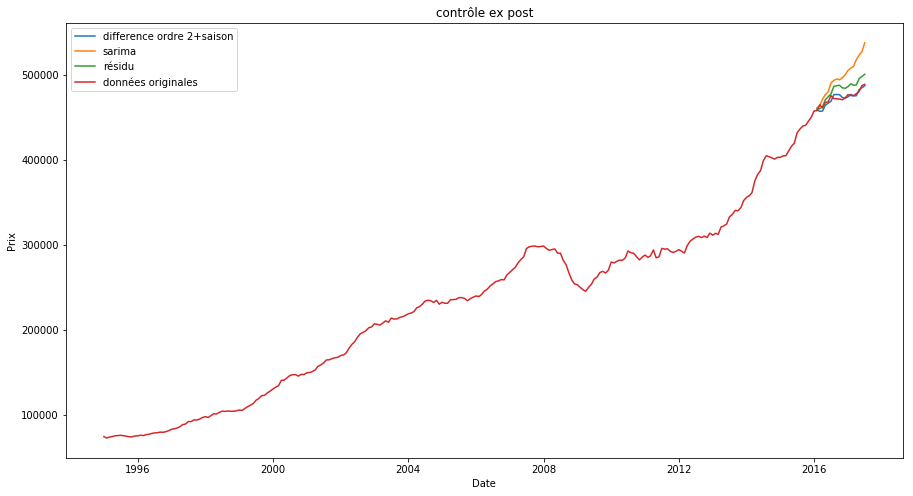

In [446]:
plt.plot(final['diff'], label="difference ordre 2+saison")
plt.plot(final['sarima'], label="sarima")
plt.plot(final['residu'], label="résidu")
plt.plot(final['Average_Price'], label="données originales")
plt.xlabel('Date')
plt.ylabel('Prix')
plt.title('contrôle ex post')
plt.legend()
plt.show()

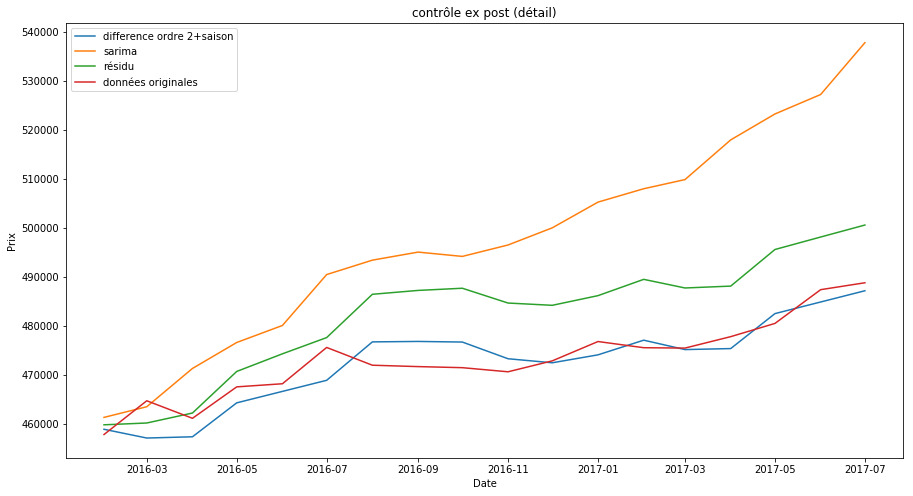

In [447]:
plt.plot(reserve_df['diff'], label="difference ordre 2+saison")
plt.plot(reserve_df['sarima'], label="sarima")
plt.plot(reserve_df['residu'], label="résidu")
plt.plot(reserve_df['Average_Price'], label="données originales")
plt.xlabel('Date')
plt.ylabel('Prix')
plt.title('contrôle ex post (détail)')
plt.legend()
plt.show() 

In [451]:
#rmse et mape de dif2

rmse = ((reserve_df['diff'] - reserve_df['Average_Price']) ** 2).mean() ** .5
print("rmse diff : {}".format(rmse))

mape = mean_absolute_percentage_error(reserve_df['Average_Price'], reserve_df['diff'])
print("mape diff : {}".format(mape))

rmse : 3679.077870736863
mape : 0.6510960628208752


In [453]:
#rmse et mape des autres
rmse = ((reserve_df['sarima'] - reserve_df['Average_Price']) ** 2).mean() ** .5
print("rmse sarima : {}".format(rmse))

mape = mean_absolute_percentage_error(reserve_df['Average_Price'], reserve_df['sarima'])
print("mape sarima : {}".format(mape))

rmse = ((reserve_df['residu'] - reserve_df['Average_Price']) ** 2).mean() ** .5
print("rmse residu : {}".format(rmse))

mape = mean_absolute_percentage_error(reserve_df['Average_Price'], reserve_df['residu'])
print("mape residu : {}".format(mape))

rmse sarima : 27849.41280911867
mape sarima : 5.106637003186529
rmse residu : 10896.760108947088
mape residu : 2.034441132980252


In [ ]:
#PFIOUUUUUUUUUU